## Visualize Ground-Truth Shape Hierarchy of Graphs and Edge Relationships

 semantic part num (Chair): 56
 semantic part num (Table): 50
 semantic part num (Bed): 24
 semantic part num (Lamp): 28
 semantic part num (Storage_Furniture): 37


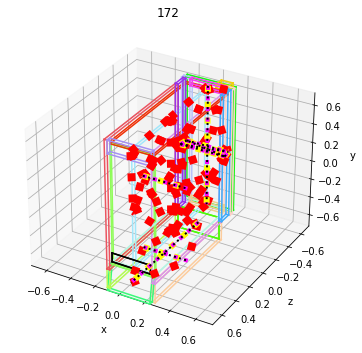

PartNet Hierarchy: (the number in bracket corresponds to PartNet part_id)
0 storage_furniture    
  ├0 cabinet    
  |  ├0 cabinet_frame    
  |  |  ├0 vertical_side_panel [LEAF] 
  |  |  ├1 vertical_side_panel [LEAF] 
  |  |  ├2 vertical_divider_panel [LEAF] 
  |  |  ├3 back_panel [LEAF] 
  |  |  ├4 bottom_panel [LEAF] 
  |  |  ├5 top_panel [LEAF] 
  |  |  ├6 frame_vertical_bar [LEAF] 
  |  |  ├7 frame_vertical_bar [LEAF] 
  |  |  ├8 frame_horizontal_bar [LEAF] 
  |  |  ├9 frame_horizontal_bar [LEAF] 
  |  |  ├10 frame_vertical_bar [LEAF] 
  |  |  ├11 frame_vertical_bar [LEAF] 
  |  |  ├12 frame_horizontal_bar [LEAF] 
  |  |  ├13 other [LEAF] 
  |  ├1 cabinet_base    
  |  |  ├0 panel_base    
  |  |  |  ├0 base_side_panel [LEAF] 
  |  |  |  ├1 base_side_panel [LEAF] 
  |  |  |  ├2 base_side_panel [LEAF] 
  |  |  |  ├3 base_side_panel [LEAF] 
  |  ├2 cabinet_door    
  |  |  ├0 cabinet_door_surface [LEAF] 
  |  |  ├1 handle [LEAF] 



In [5]:
%matplotlib inline

import os
import matplotlib
from data import FrontDatasetPartNet
from vis_utils import draw_partnet_objects
from treebase import Chair, Table, Bed, Lamp, Storage_Furniture
Object_cates = ['Chair', 'Table', 'Bed','Lamp' ,'Storage_Furniture']
cates_class = [Chair, Table, Bed,Lamp, Storage_Furniture]
for id, cate_id in enumerate(Object_cates):
    cur_Tree = cates_class[id]
    cur_Tree.load_category_info(cate_id, cur_Tree)

matplotlib.pyplot.ion()

# ground-truth data directory
root_dir = '../data/partnetdata/chair_hier'

# read all data
obj_list = sorted([int(item.split('.')[0]) for item in os.listdir(root_dir) if item.endswith('.json')])

# visualize one data
obj_id = 0
obj = FrontDatasetPartNet.load_object('B:\\SceneEvolutionGraph\\structurenet\\data\\partnetdatanew\\45130.json',Storage_Furniture)

# edge visu: ADJ (red), ROT_SYM (yellow), TRANS_SYM (purple), REF_SYM (black)
draw_partnet_objects(objects=[obj], object_names=[str(obj_list[obj_id])], 
                     figsize=(9, 5), leafs_only=True, visu_edges=True,
                     sem_colors_filename='../stats/semantics_colors/Chair.txt')

print('PartNet Hierarchy: (the number in bracket corresponds to PartNet part_id)')
print(obj)

## Box-shape AE Reconstruction

 semantic part num (Chair): 56
 semantic part num (Table): 50
 semantic part num (Bed): 24
 semantic part num (Lamp): 28
 semantic part num (Storage_Furniture): 37
Using Symmetric Type: max
Using Symmetric Type: max
Using Symmetric Type: max
Using Symmetric Type: max
Using Symmetric Type: max
../data/results/box_ae_storagefurniture\44992
torch.Size([1, 256])
box pc chamfer distance: 0.054536815732717514
structure distance: 0.38235294117647056
edge precision: 0.7058823529411765
edge recall: 0.46153846153846156
pred binary diff: 0.023261819115849028
gt binary diff: 0.048362492807209494


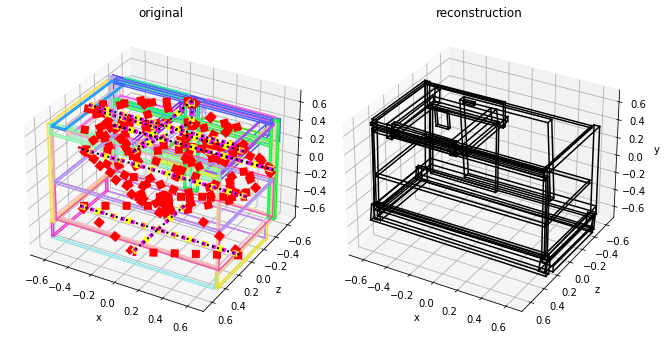

In [4]:
%matplotlib inline

import json
import os
import numpy as np
import torch
import trimesh
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx
import pickle
import chamfer_distance
import torch
from model_structure_net_box import RecursiveEncoder,RecursiveDecoder
from data import SceneTree,FrontDatasetPartNet
import random
from treebase import Chair, Table, Bed, Lamp, Storage_Furniture
from collections import namedtuple
import math
import traceback
import os
import matplotlib
from data import FrontDatasetPartNet
from vis_utils import draw_partnet_objects
from treebase import Chair, Table, Bed, Lamp, Storage_Furniture
Object_cates = ['Chair', 'Table', 'Bed','Lamp' ,'Storage_Furniture']
cates_class = [Chair, Table, Bed,Lamp, Storage_Furniture]
for id, cate_id in enumerate(Object_cates):
    cur_Tree = cates_class[id]
    cur_Tree.load_category_info(cate_id, cur_Tree)

category_class = [
    "Storage_Furniture", 
    "Table",
    "Chair", 
    "Bed", 
   # "Sofa",
    "Lamp",
    "Moveable"
]
encoders = {}
decoders = {}
for cat in category_class:
    if cat == 'Moveable' : continue

    config = torch.load('../data/models/PartNetBox_vae_' + cat + '/conf.pth')
    #print(config)
    #print(cat)
    encoders[cat] = RecursiveEncoder(config,variational=True,Tree=cates_class[Object_cates.index(cat)])
    encoders[cat].load_state_dict(torch.load('../data/models/PartNetBox_vae_' + cat + '/net_encoder.pth'), strict=True)
    decoders[cat] = RecursiveDecoder(config,Tree=cates_class[Object_cates.index(cat)])
    decoders[cat].load_state_dict(torch.load('../data/models/PartNetBox_vae_' + cat + '/net_decoder.pth'), strict=True)

matplotlib.pyplot.ion()

# results directory
root_dir = '../data/results/box_ae_storagefurniture'

# read all data
obj_list = sorted([int(item) for item in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, item))])

# visualize one data
obj_id = 2
obj_dir = os.path.join(root_dir, str(obj_list[obj_id]))
print(obj_dir)

# visualize one data
obj_id = 0
obj = FrontDatasetPartNet.load_object('B:\\SceneEvolutionGraph\\structurenet\\data\\partnetdatanew\\45238.json',Storage_Furniture)
root_code = encoders['Storage_Furniture'].encode_structure(obj)
print(root_code.shape)
recon_obj = decoders['Storage_Furniture'].decode_structure(root_code[0,:128].reshape(1,128),max_depth=100)


stat_filename = os.path.join(obj_dir, 'stats.txt')
with open(stat_filename, 'r') as stat_file:
    stats = stat_file.readlines()
stats = [x.strip() for x in stats]
stats = list(filter(None, stats))
for stat in stats:
    print(stat)

draw_partnet_objects(objects=[obj, recon_obj], object_names=['original', 'reconstruction'], 
                     figsize=(9, 5), leafs_only=True, visu_edges=True,
                     sem_colors_filename='../stats/semantics_colors/StorageFurniture.txt')



## Box-shape VAE Free Generation

In [2]:
%matplotlib notebook

import os
import matplotlib
from data import PartNetDataset
from vis_utils import draw_partnet_objects

matplotlib.pyplot.ion()

# results directory
root_dir = '../data/results/box_vae_chair'

# read all data
obj_list = sorted([item for item in os.listdir(root_dir) if item.endswith('.json')])

# visualize one data
obj_id = 0
obj = PartNetDataset.load_object(os.path.join(root_dir, obj_list[obj_id]))

draw_partnet_objects(objects=[obj], object_names=[obj_list[obj_id]], 
                     figsize=(9, 5), leafs_only=True, visu_edges=True, 
                     sem_colors_filename='../stats/semantics_colors/Chair.txt')

print('Tree Structure:')
print(obj)

ImportError: cannot import name 'PartNetDataset' from 'data' (b:\SceneEvolutionGraph\structurenet\code\data.py)